In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots
import os

plt.style.use(['science', 'ieee', 'no-latex'])
plt.rcParams['font.size'] = 7
plt.rcParams['axes.labelsize'] = 7

def format(mirror: str) -> int:

    m, n = mirror[:2],  int(mirror[2:])

    if m == 'll': n+= 0
    if m == 'lm': n+= 7
    if m == 'la': n+= 14
    if m == 'co': n+= 21
    if m == 'he': n+= 28

    return n

In [ ]:
runlist_dir = '/home/filip/xy-calibration/config/calib_runlists/'
source_dir = '/home/filip/xy-calibration/results/'

reject = [''
          '15952x',     # co2 due to ??? (ASK!!!!!!!!!!)
          '15920x',     # co5 due to curtain in aperture
          '6075',       # he2 due to cold electronics
          ]

# fig, axes = plt.subplots(4, 1, sharex=True)

figs_and_axes = [plt.subplots(1, 2, sharey=True) for _ in range(5)]
figs, axes = [a[0] for a in figs_and_axes], [a[1] for a in figs_and_axes]

for (ax1, ax2), list, fig in zip(axes, ['2019-11', '2022-10', '2023-10', '2023-11', '2024-11'], figs):

    ax1.set_yticks([], minor = True)
    ax1.set_yticklabels([], fontsize=5)
    ax1.set_xticks(np.arange(0.8, 1.8, 0.05), minor=True)   # set minor ticks on x-axis
    ax2.set_xticks(np.arange(0.8, 1.8, 0.05), minor=True)   # set minor ticks on x-axis
    ax1.set_xticks(np.arange(0.8, 1.9, 0.2))
    ax2.set_xticks(np.arange(0.8, 1.9, 0.2))
    ax1.set_ylim(0, 32)

    ax1.text(0, 1, f"{list} - raw calib.", transform=ax1.transAxes,
            ha='left', va='bottom', fontsize='large', fontweight='bold')
    ax2.text(0, 1, f"{list} - calib. corr.", transform=ax2.transAxes,
            ha='left', va='bottom', fontsize='large', fontweight='bold')
    ax1.set_xlabel(r"Cal XY raw / std. Cal")
    ax2.set_xlabel(r"Cal XY corr. / std. Cal")
    ax1.set_xlim(0.8, 1.8)
    ax2.set_xlim(0.8, 1.8)
    ax1.grid(axis='x')
    ax2.grid(axis='x')
    ax1.grid(axis='x', which='minor', alpha=0.3)
    ax2.grid(axis='x', which='minor', alpha=0.3)

    with open(f'{runlist_dir}calib_runs_{list}.list', 'r') as f:
        header = f.readline().strip().split(';')

    df = pd.read_csv(f'{runlist_dir}/calib_runs_{list}.list',
                     comment='#', delimiter=';', names=header)
    
    pos, label, data, data_corr = [], [], [], []

    for i, run in df.iterrows():
        if run['#runid'].strip() in reject: continue
        if not run['forDB']: continue
        if not run['source'].strip() in ['"OLO"', "OLO"]: continue
        if not run['comment'].strip() != '': continue

        try:

            cal_xy, cal_std, cal_xy_corr = np.loadtxt(f'{source_dir}/outCorr_{run["#runid"]}.txt', usecols=[1, 3, 4], unpack=True)
            # if run['#runid'] in ['12806', '12809']:
            #     cal_std = np.loadtxt(f'{runlist_dir}/../../save_{run["#runid"].strip()}.txt', usecols=[3])

            if os.path.isfile(pixel_mask_file := f'{runlist_dir}/../pixel_masks/{run["telescope"].strip()}.txt'):
                pixel_mask = np.loadtxt(pixel_mask_file, usecols=[-1], dtype=bool)
            else:
                pixel_mask = np.ones(440, dtype=bool)

            cal_xy[~pixel_mask] = np.nan
            cal_xy_corr[~pixel_mask] = np.nan

            pos.append(format(run['telescope'].strip()))
            label.append(run['telescope'].strip().upper())
            data.append(cal_xy / cal_std)
            data_corr.append(cal_xy_corr / cal_std)

            # os.system(f'mkdir -p /home/filip/Desktop/pixel_constants/{list}/')
            # np.savetxt(f'/home/filip/Desktop/pixel_constants/{list}/{run["telescope"].strip()}', 
            #            np.column_stack([np.arange(1, 441, 1), data[-1], data_corr[-1]]), fmt='%s')

        except FileNotFoundError: 
            continue
        
    # pixel calibConst adcSum stdCalib calibConstCorr
    ax1.boxplot(data, positions=pos, vert=False, tick_labels=label, showfliers=False, widths=0.5)
    ax2.boxplot(data_corr, positions=pos, vert=False, tick_labels=label, showfliers=False, widths=0.5)

    plt.subplots_adjust(hspace=0)
    # raise StopIteration

    # np.savetxt(f'/home/filip/Desktop/{list}.txt', np.column_stack([label, np.nanmedian(data, axis=1), np.nanmedian(data_corr, axis=1)]), fmt='%s')
    fig.savefig(f'/home/filip/Desktop/pixel_constants/{list}.png')

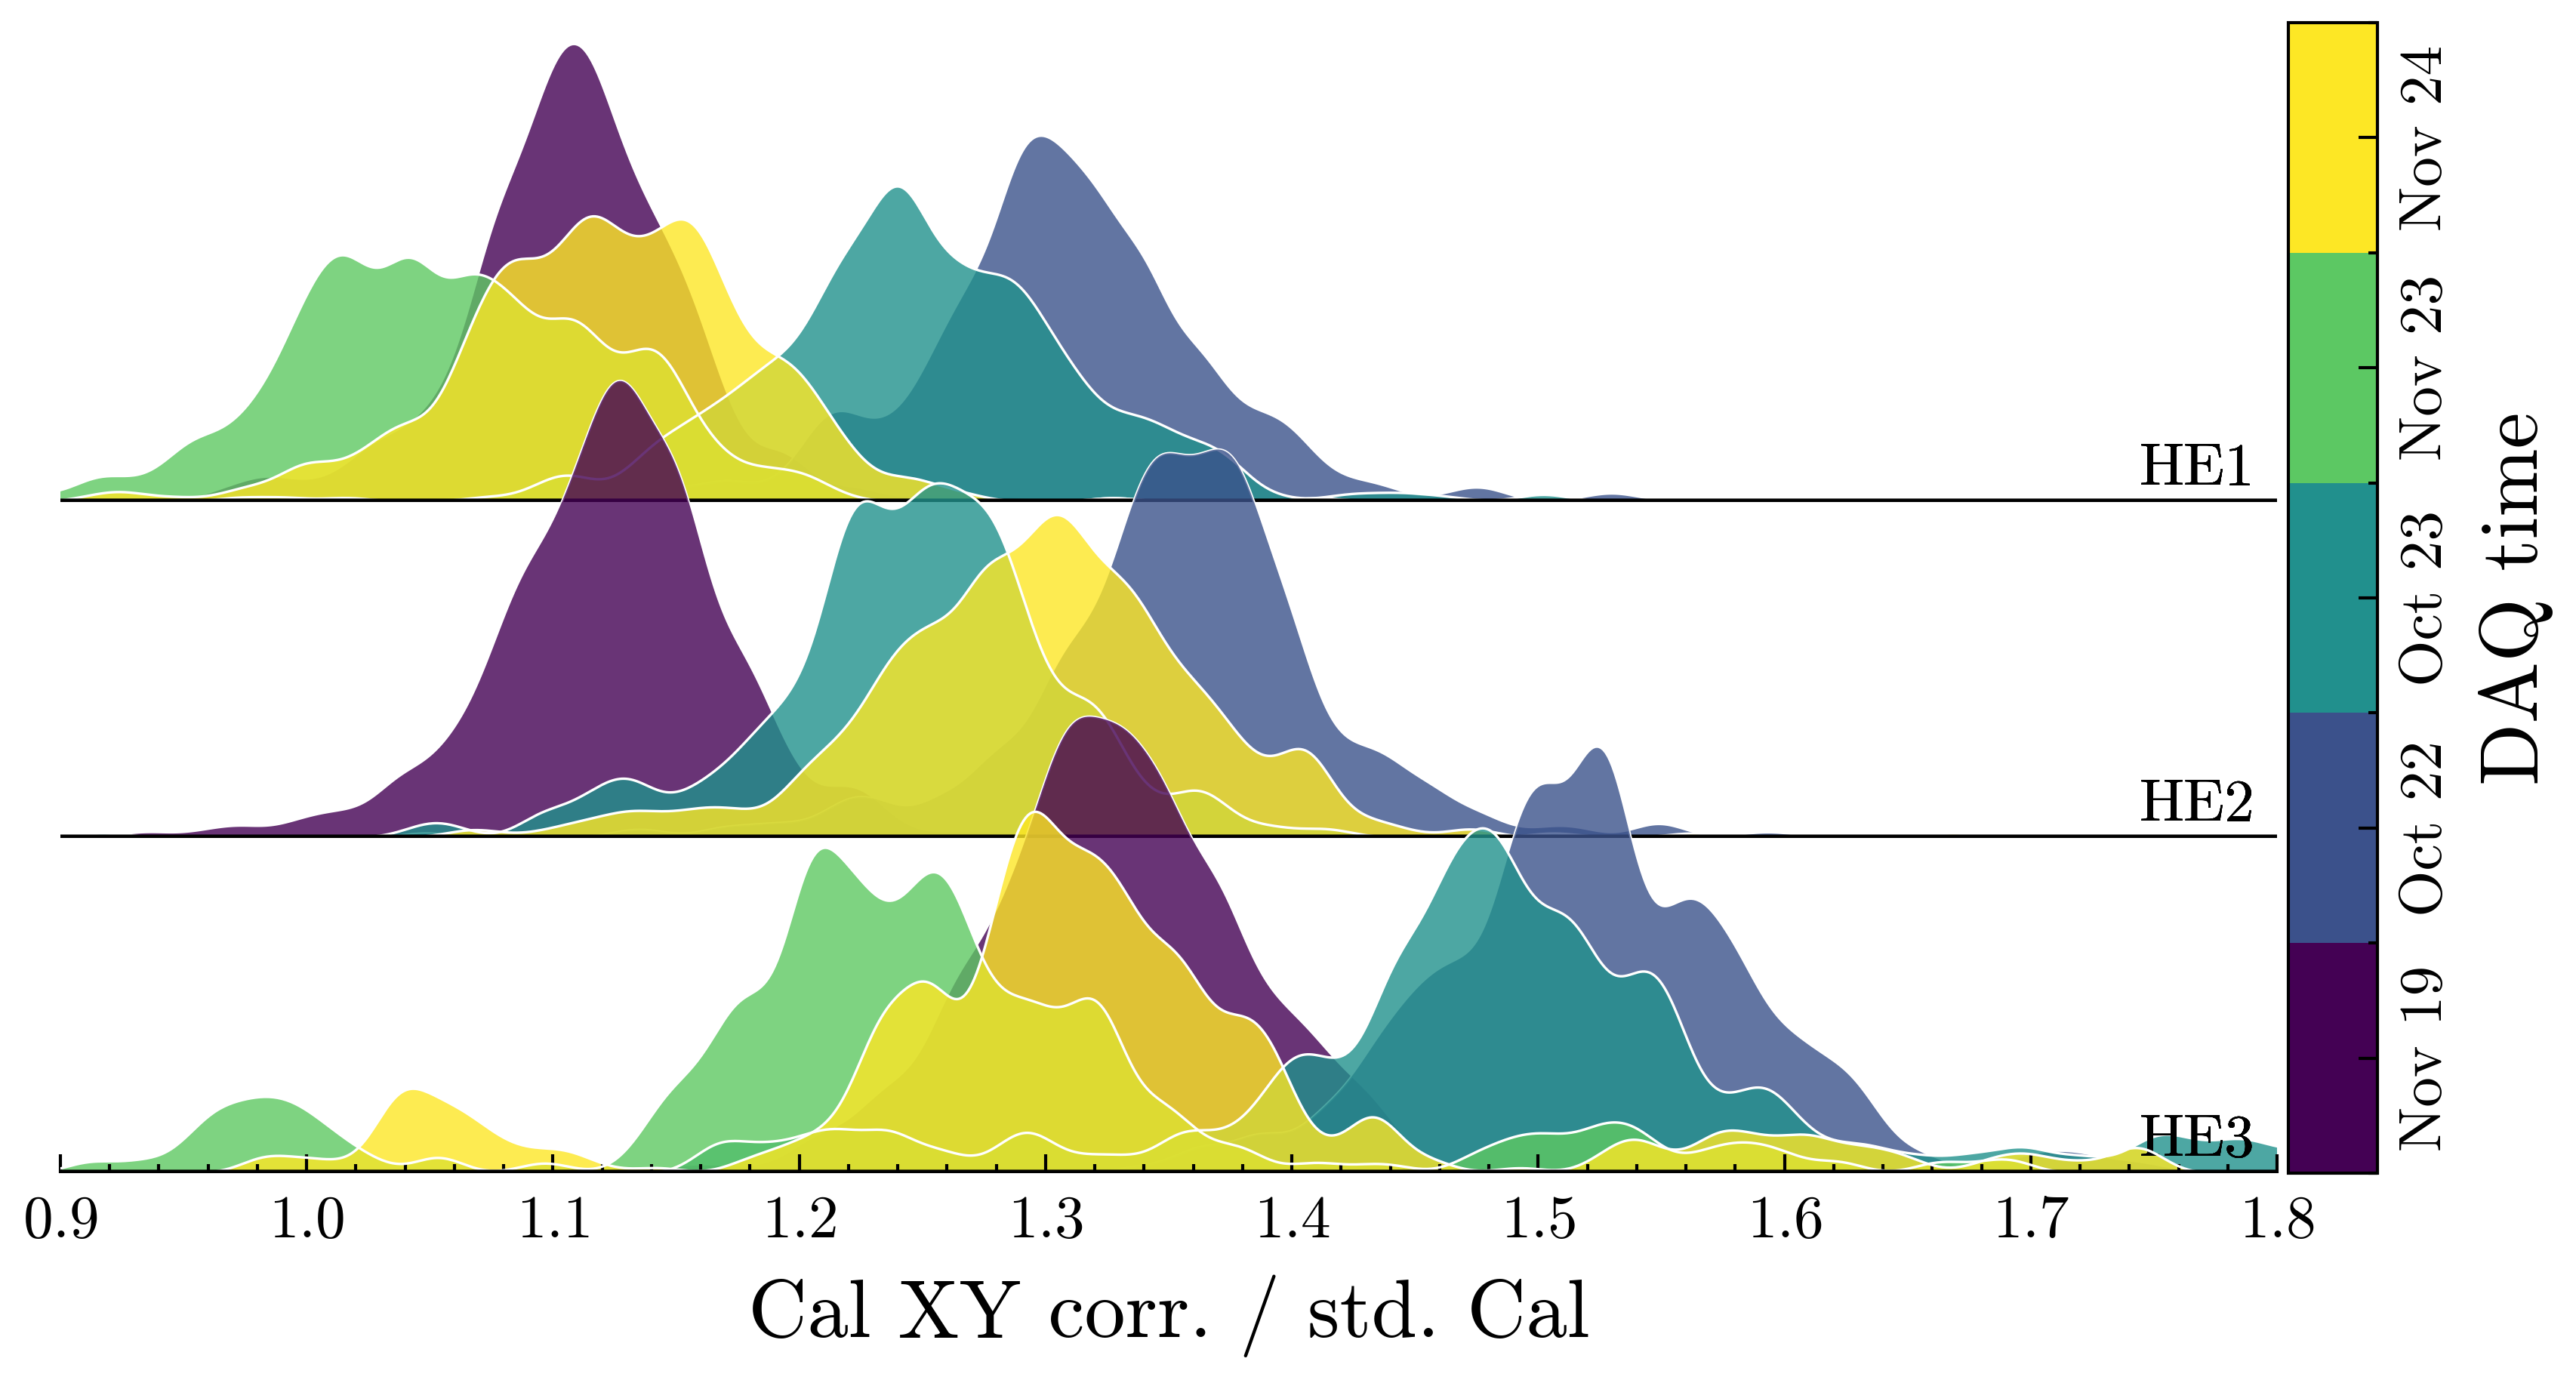

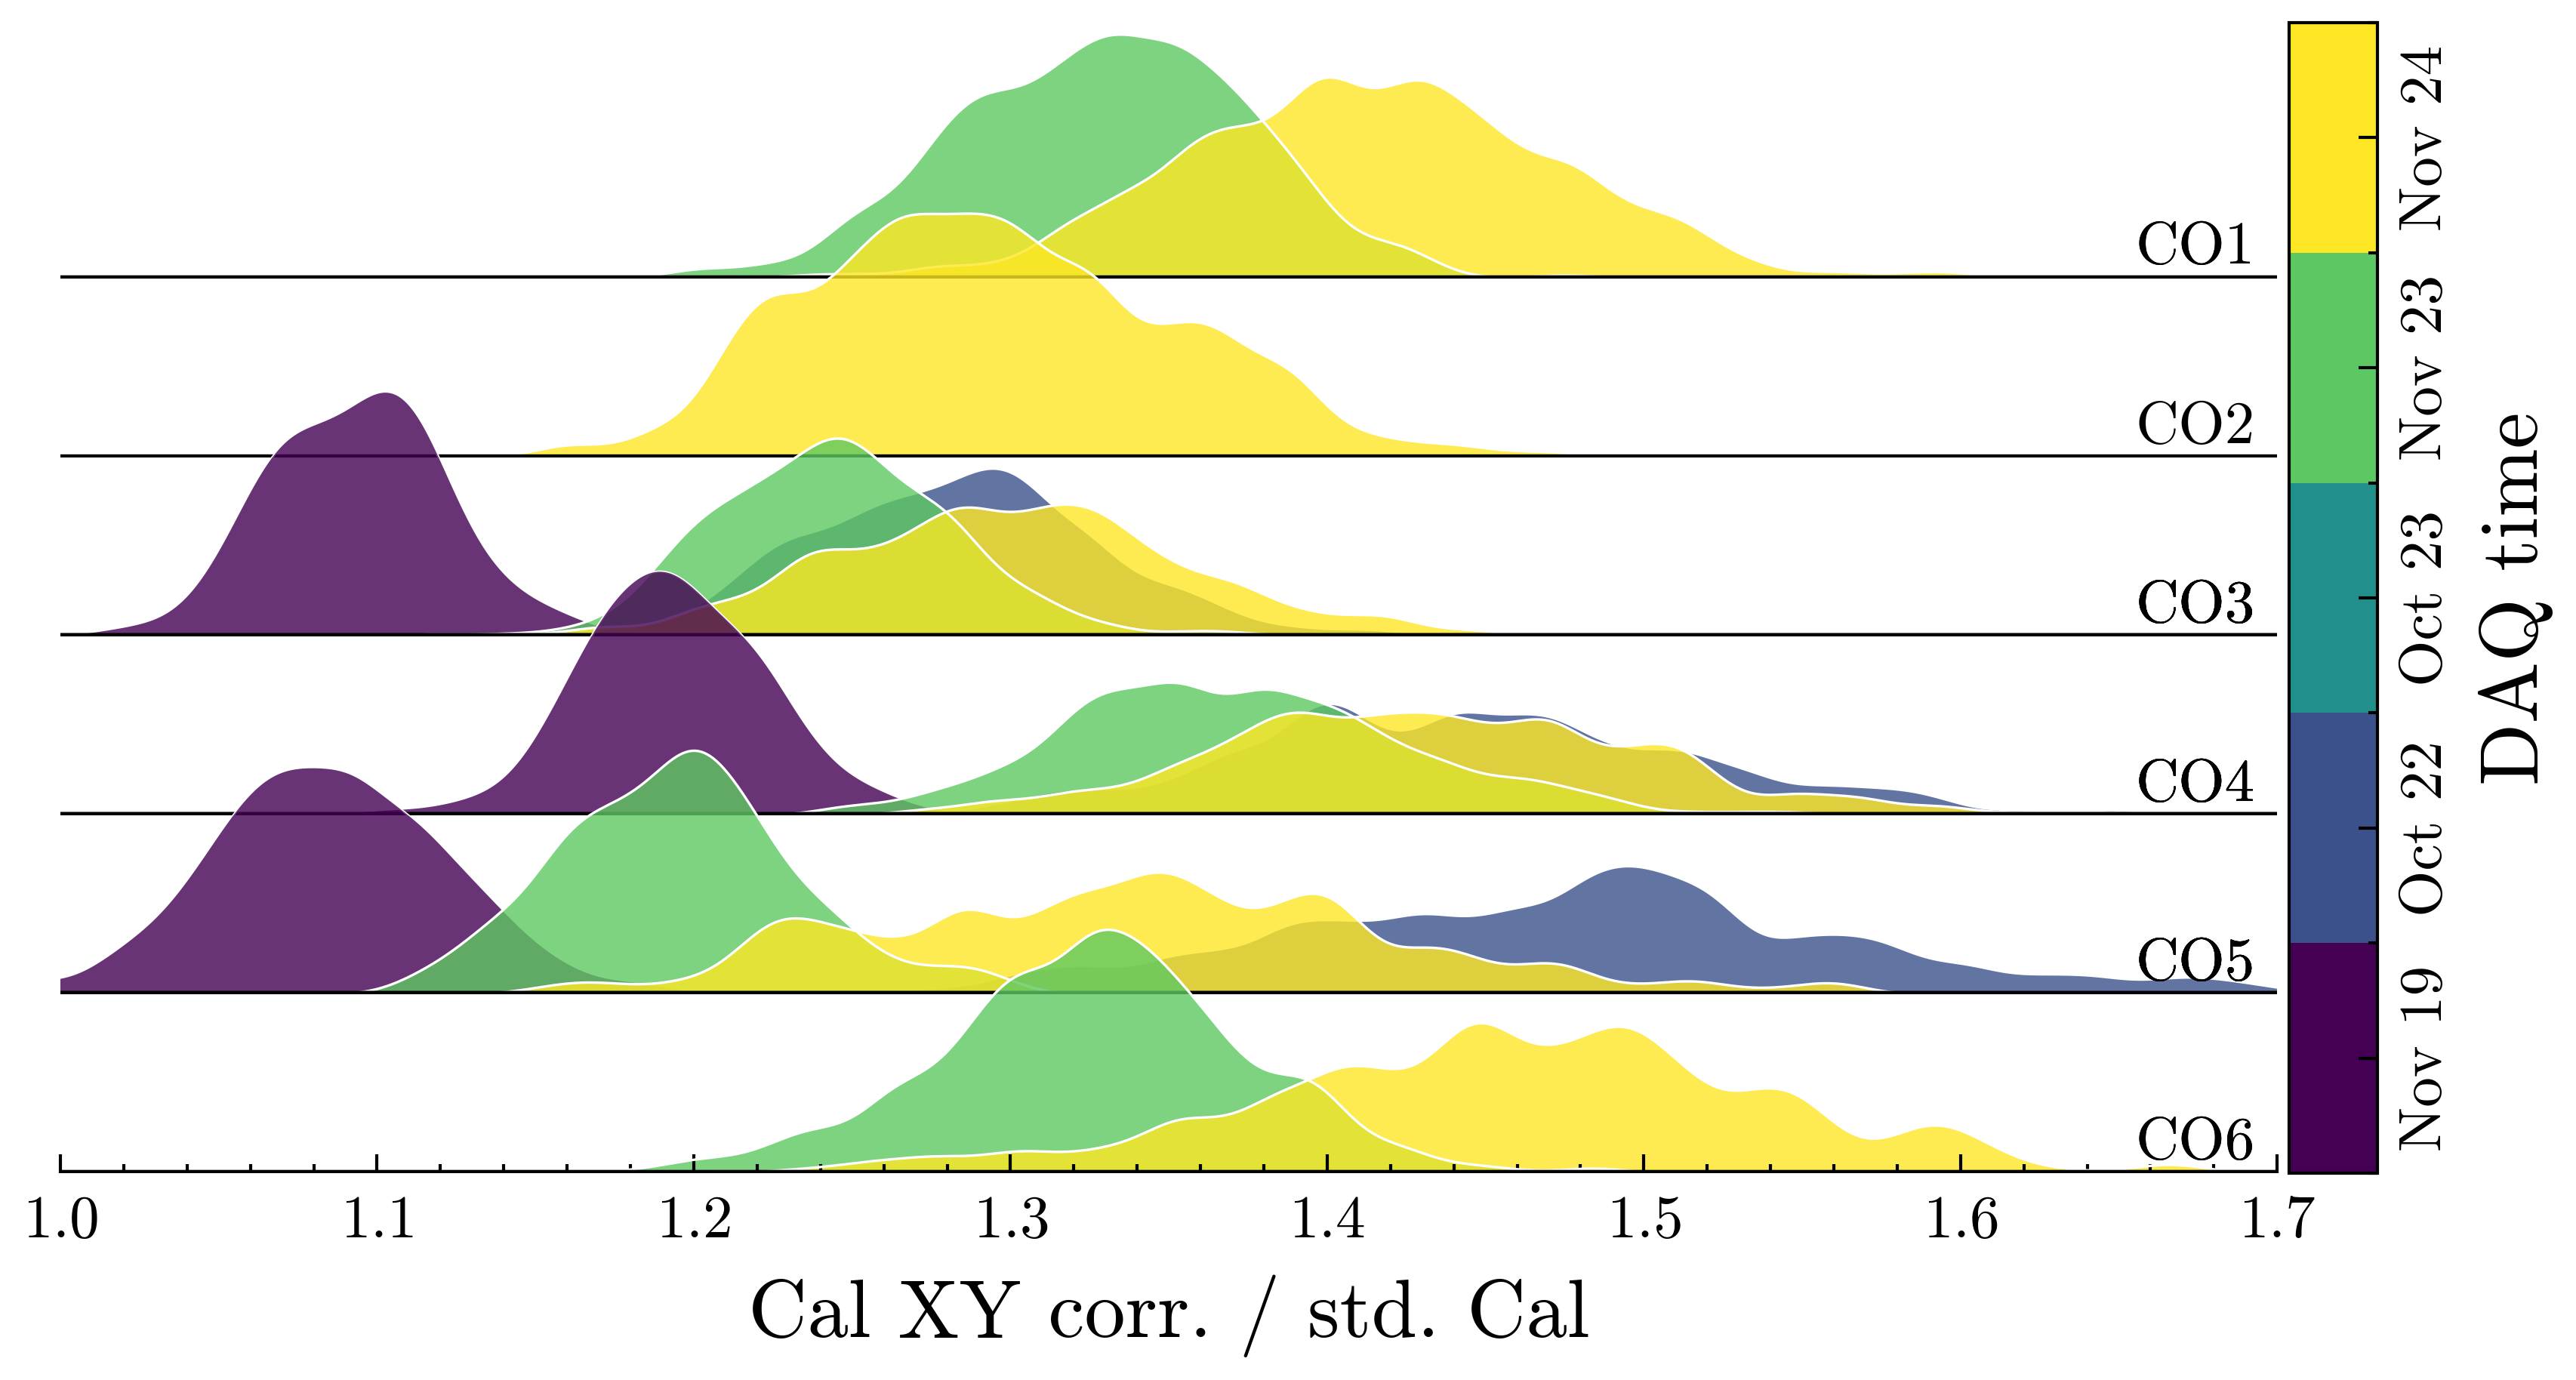

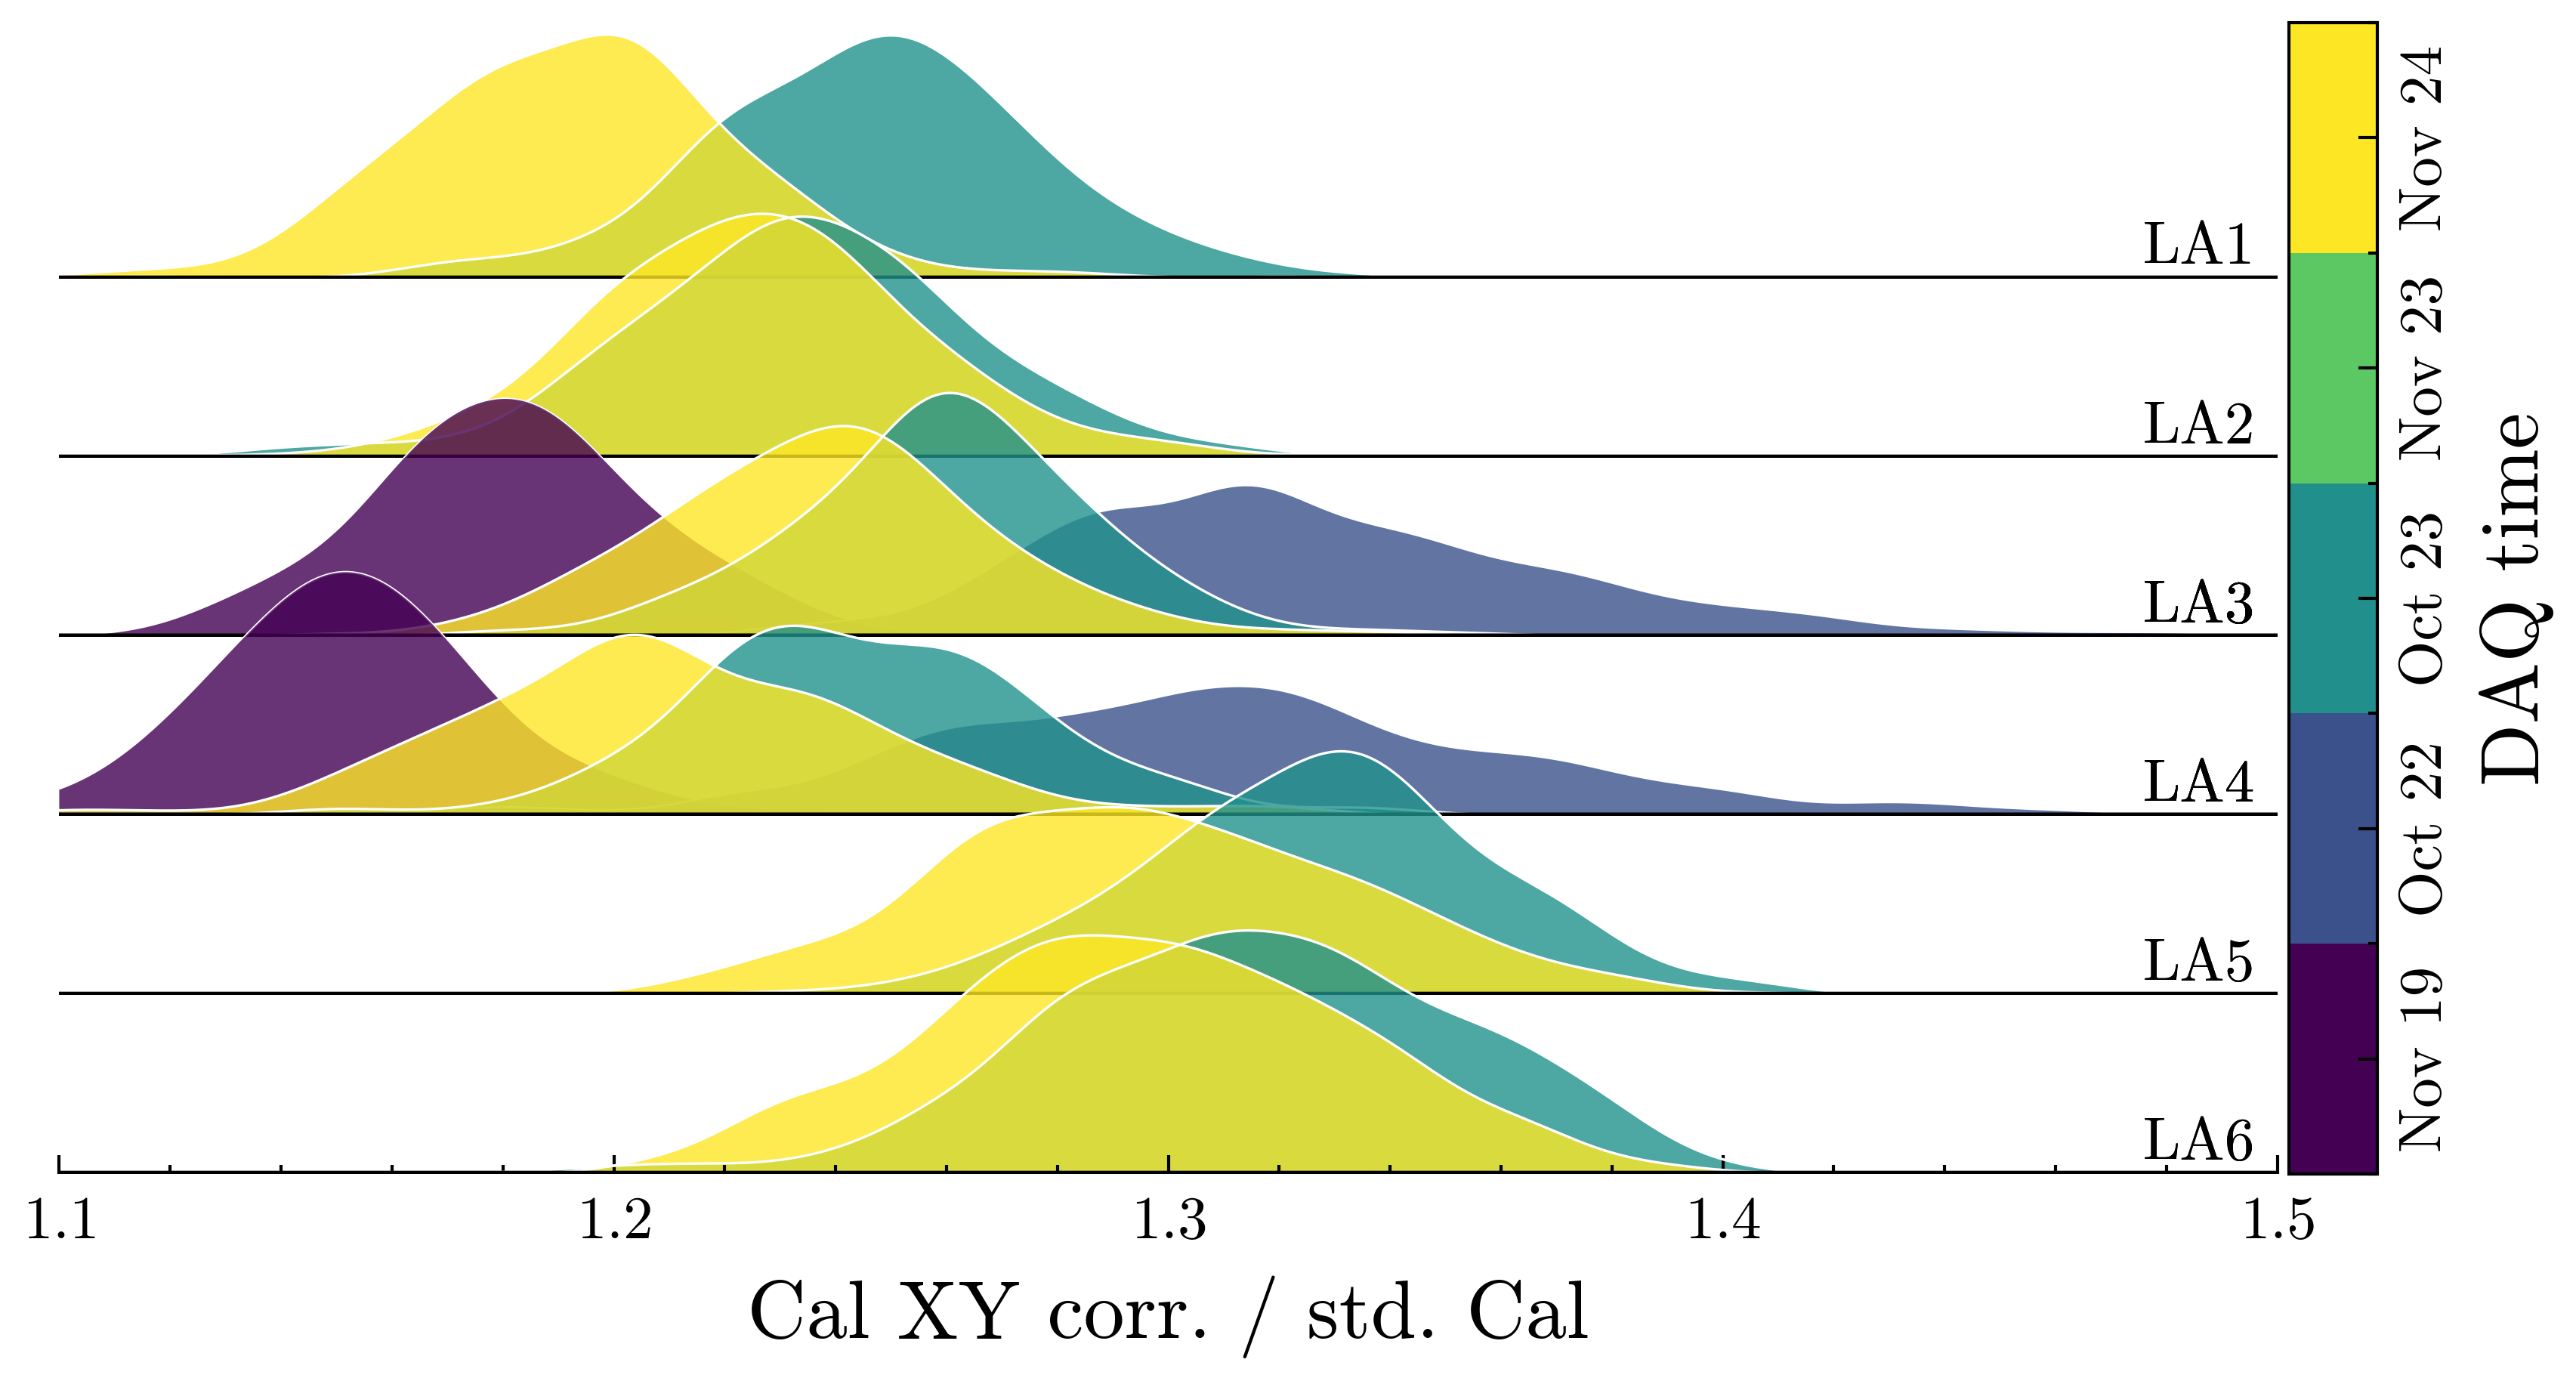

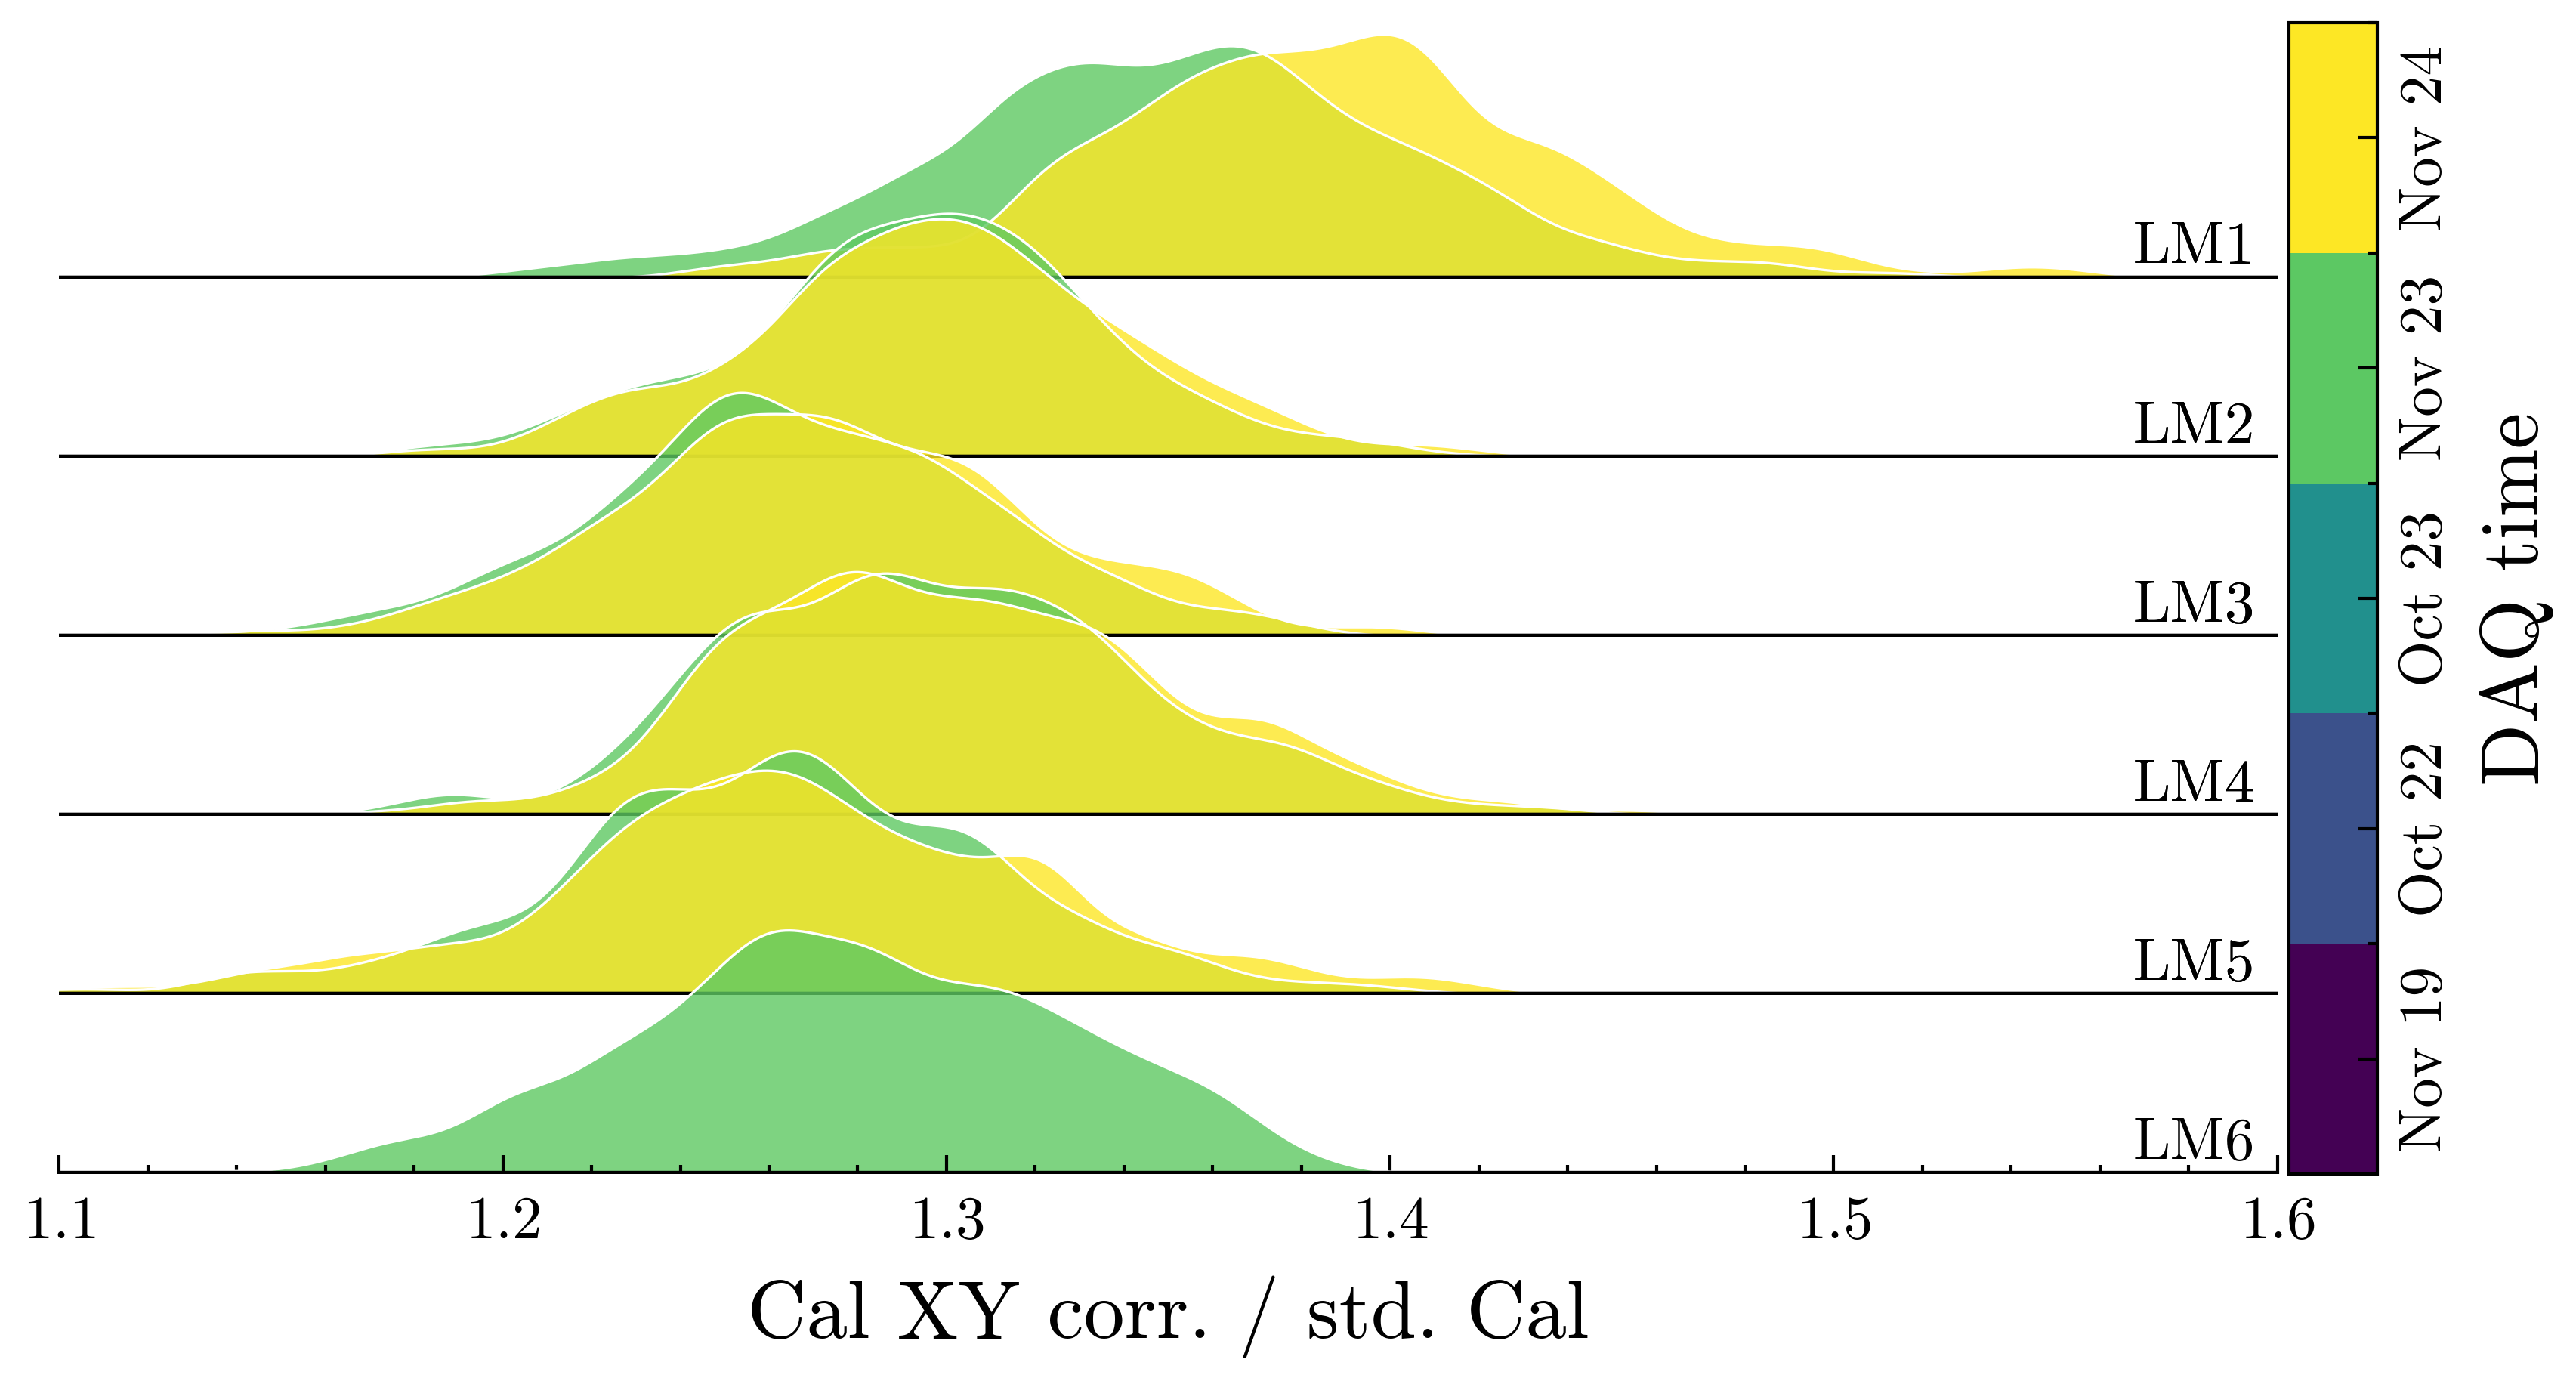

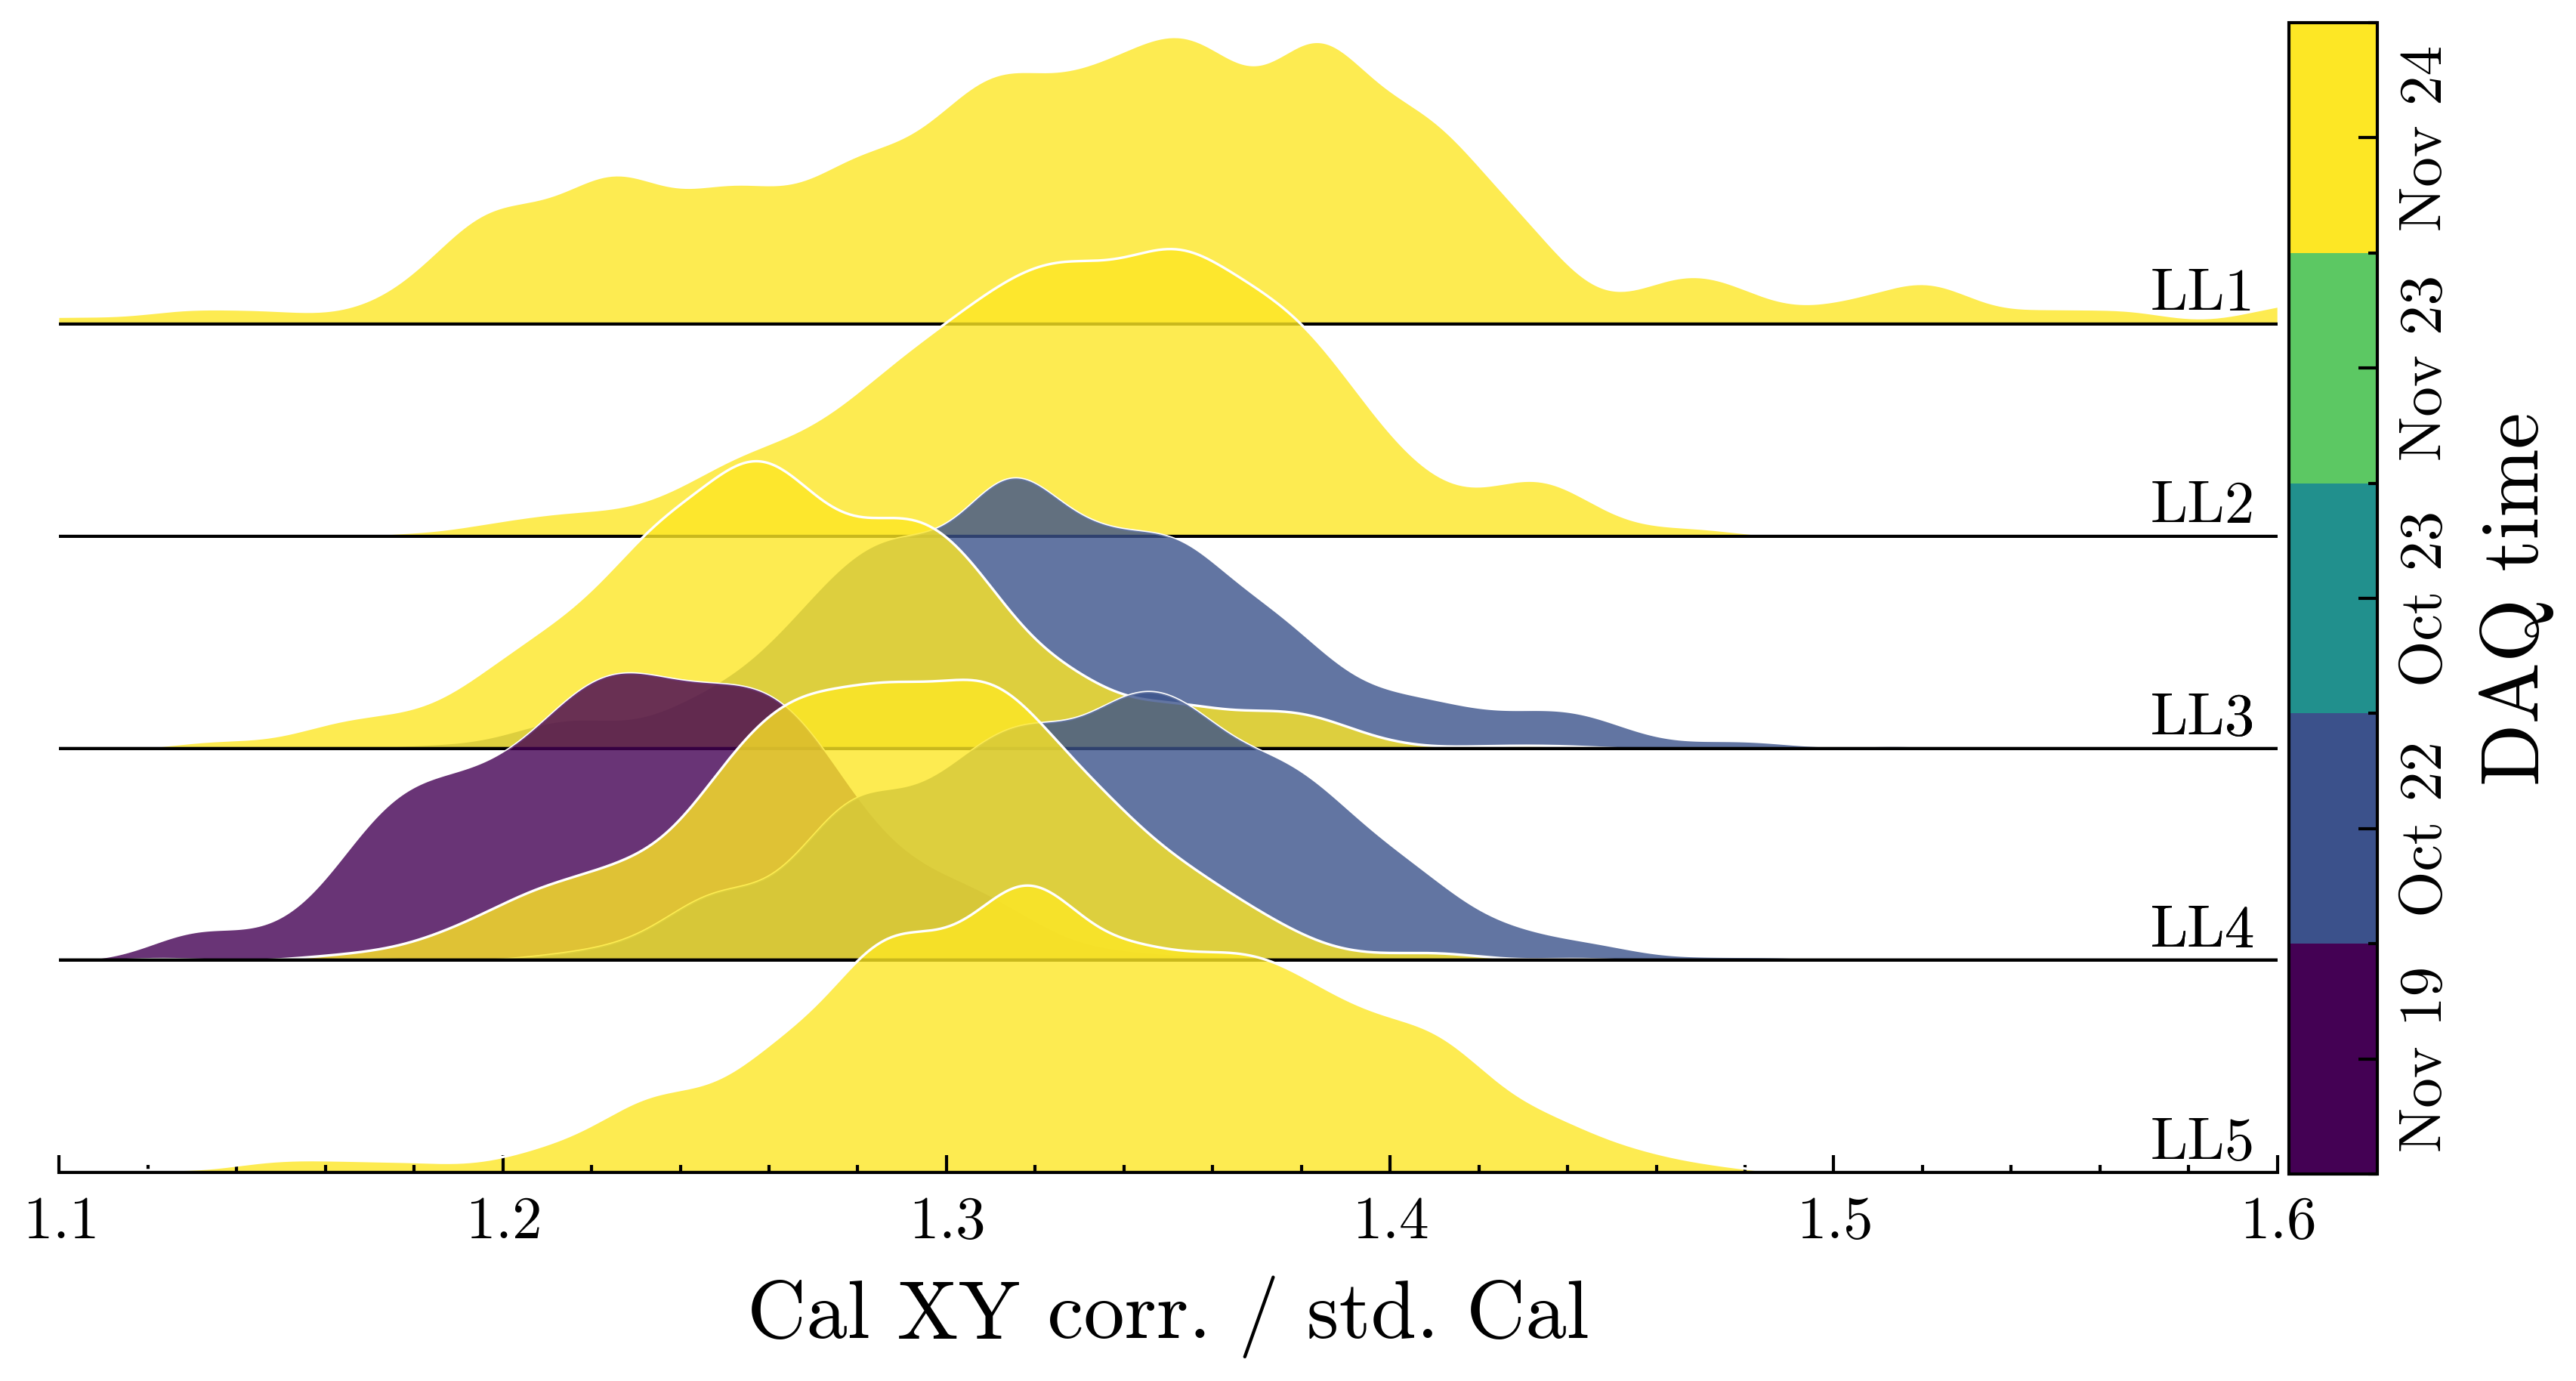

In [16]:
from utils.binaries import *
from utils.plotting import *
from matplotlib.gridspec import GridSpec
from datetime import datetime, timedelta
import os

from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import ScalarMappable

# XMIN, XMAX = 1, 1.6

cmap = plot.gradient(plt.cm.viridis, 5)
def calculate_color(date):

    cmap = plt.cm.viridis
    min, max = datetime(2019, 11, 1), datetime(2024, 11, 1)
    date = datetime.strptime(date, '%Y-%m')
    _range = (max - min).total_seconds()
    _x = (date - min).total_seconds()

    return cmap(_x / _range)

def calculate_date(tick, _):
    min, max = datetime(2019, 11, 1), datetime(2024, 11, 1)
    _range = (max - min).total_seconds()
    return datetime.strftime(min + timedelta(seconds=tick*_range), "%y/%m")

os.chdir('/home/filip/Desktop/pixel_constants/')
for tel in ['he', 'co', 'la', 'lm', 'll']:

    XMIN = {
        "he": 0.9,
        "co": 1.0,
        "la": 1.1,
        "lm": 1.1,
        "ll": 1.1,
    }
    
    XMAX = {
        "he": 1.8,
        "co": 1.7,
        "la": 1.5,
        "lm": 1.6,
        "ll": 1.6,
    }
    X = np.linspace(XMIN[tel], XMAX[tel], 1000)

    match tel:
        case 'he': tel_number = 3
        case 'll': tel_number = 5
        case   _ : tel_number = 6

    fig = plt.figure()
    gs = GridSpec(
        tel_number, 2,
        fig, hspace=-0.3,
        wspace=0.01,
        width_ratios=[1, 0.04]
    )

    axes = [fig.add_subplot(gs[i, 0]) for i in range(tel_number)]
    cax = fig.add_subplot(gs[:, 1])

    # fig, axes = plt.subplots(6 if tel != 'he' else 3, 1, gridspec_kw={'hspace': -0.3})

    years = os.listdir()
    years.sort()
    for year in years:

        i = {
            "2019-11": 0,
            "2022-10": 1,
            "2023-10": 2,
            "2023-11": 3,
            "2024-11": 4
        }

        if not os.path.isdir(year): continue
        for bay in os.listdir(year):
            if not bay.startswith(tel): continue
            if "." in bay: continue

            ax_index = int(bay[-1]) - 1
            # color = calculate_color(year)
            color = cmap[i[year]]

            ratio = np.loadtxt(f"{year}/{bay}", usecols=[-1])
            mask = np.logical_or(np.isinf(ratio), np.isnan(ratio))
            Y = tools.kd1d_estimate(ratio[~mask], bandwidth=1e-2)(X)
            axes[ax_index].plot(X, Y, c='w', marker='none', ls='solid', lw=0.4, zorder=i[year])
            fill = axes[ax_index].fill_between(X, Y, alpha=0.8, color=color, ec='none')

            axes[ax_index].axhline(0, c='k', zorder=10)
            axes[ax_index].text(0.99, 0.01, bay.upper(), transform=axes[ax_index].transAxes,
                                ha='right', va='bottom')
    
    spines = ["top","right","left","bottom"]
    for ax in axes: 
        for s in spines: ax.spines[s].set_visible(False)
        ax.set_ylim(0)
        ax.patch.set_alpha(0)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_xlim(XMIN[tel], XMAX[tel])

    ax.set_xticks(np.arange(XMIN[tel], XMAX[tel] + 0.01, 0.1))
    ax.xaxis.set_ticks_position("bottom")

    # norm = Normalize(0, 1)
    norm = BoundaryNorm(np.arange(-0.5, 5.5, 1), plt.cm.viridis.N)
    mappable = ScalarMappable(norm, plt.cm.viridis)
    plt.colorbar(mappable, cax=cax, label='DAQ time')
    cax.set_yticks([0, 1, 2, 3, 4], ['Nov 19', 'Oct 22', 'Oct 23', 'Nov 23', 'Nov 24'],
                   rotation=90, va='center')
    # cax.yaxis.set_major_formatter(calculate_date)
    # plt.setp( cax.yaxis.get_majorticklabels(), rotation=-15)

    ax.set_xlabel(r"Cal XY corr. / std. Cal")

    fig.savefig(f'per_telescope/{tel}.png')

